# Comparing Deep learning Models:
- Identify the best DL model which classifies offensive and non-offensive tweets accurately from 6,463 labeled tweets
- Models tested were: **CNN, LSTM, CNN-LSTM, BiLSTM & CNN-BiLSTM**


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
base_path = "/content/drive/MyDrive/MRP_Offensive_Content_Detection/Final_Dataset/"
df = pd.read_csv(base_path + 'mrp_final_dataset.csv')

In [ ]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
df['label'] = le.fit_transform(df['majority_label'])  # Maps labels to integers

In [ ]:
df['label'].value_counts()

,count
label,
1,3584
0,2879


In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, MaxPooling1D, LSTM, Bidirectional, Dense, Dropout, Flatten
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, accuracy_score
import random
import os

In [ ]:
def set_seed(seed=42):
    tf.random.set_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)

set_seed(42)

In [ ]:
train_eval_df, final_test_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df['label'])
train_df, val_df = train_test_split(train_eval_df, test_size=0.1, random_state=42, stratify=train_eval_df['label'])

tokenizer = Tokenizer(num_words=20000, oov_token='<OOV>')
tokenizer.fit_on_texts(train_df['text'])

def prepare_data(texts, tokenizer, max_len=100):
    sequences = tokenizer.texts_to_sequences(texts)
    return pad_sequences(sequences, maxlen=max_len)

X_train = prepare_data(train_df['text'], tokenizer)
X_val = prepare_data(val_df['text'], tokenizer)
X_test = prepare_data(final_test_df['text'], tokenizer)

y_train = train_df['label'].values
y_val = val_df['label'].values
y_test = final_test_df['label'].values

In [ ]:
def build_cnn_model(vocab_size, embed_dim=100):
    model = Sequential([
        Embedding(vocab_size, embed_dim),
        Conv1D(128, 5, activation='relu'),
        MaxPooling1D(pool_size=2),
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(1, activation='sigmoid')
    ])
    return model

def build_lstm_model(vocab_size, embed_dim=100):
    model = Sequential([
        Embedding(vocab_size, embed_dim),
        LSTM(128),
        Dense(1, activation='sigmoid')
    ])
    return model

def build_cnn_lstm_model(vocab_size, embed_dim=100):
    model = Sequential([
        Embedding(vocab_size, embed_dim),
        Conv1D(128, 5, activation='relu'),
        MaxPooling1D(pool_size=2),
        LSTM(128),
        Dense(1, activation='sigmoid')
    ])
    return model

def build_bilstm_model(vocab_size, embed_dim=100):
    model = Sequential([
        Embedding(vocab_size, embed_dim),
        Bidirectional(LSTM(128)),
        Dense(1, activation='sigmoid')
    ])
    return model

def build_cnn_bilstm_model(vocab_size, embed_dim=100):
    model = Sequential([
        Embedding(vocab_size, embed_dim),
        Conv1D(128, 5, activation='relu'),
        MaxPooling1D(pool_size=2),
        Bidirectional(LSTM(128)),
        Dense(1, activation='sigmoid')
    ])
    return model


In [ ]:
def train_and_evaluate(model_fn, name, save=False):
    print(f"\nTraining {name}...")
    model = model_fn(vocab_size=20000)
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

    model.fit(X_train, y_train, epochs=5, batch_size=32, validation_data=(X_val, y_val), verbose=1)

    preds = (model.predict(X_test) > 0.5).astype(int)
    print(f"\n{name} Accuracy: {accuracy_score(y_test, preds)}")
    print(classification_report(y_test, preds))

    # Confusion Matrix
    cm = confusion_matrix(y_test, preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Non-offensive", "Offensive"])
    disp.plot(cmap='Purples')
    plt.title(f"{name} - Confusion Matrix")
    plt.show()

    if save:
        model.save(f"{name}.h5")



Training CNN...
Epoch 1/5
146/146 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - accuracy: 0.5871 - loss: 0.6703 - val_accuracy: 0.6809 - val_loss: 0.6050
Epoch 2/5
146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7560 - loss: 0.5017 - val_accuracy: 0.7118 - val_loss: 0.6445
Epoch 3/5
146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9069 - loss: 0.2350 - val_accuracy: 0.7215 - val_loss: 0.9149
Epoch 4/5
146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9759 - loss: 0.0672 - val_accuracy: 0.7215 - val_loss: 1.2019
Epoch 5/5
146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9965 - loss: 0.0156 - val_accuracy: 0.6905 - val_loss: 1.5095
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step

CNN Accuracy: 0.7246713070378964
              precision    recall  f1-score   support

           0       0.69      0.70      0.70       576
           1       0.76      0.74      0.75       717

    accuracy                           0.72      1293
   macro avg       0.72      0.72      0.72      1293
we

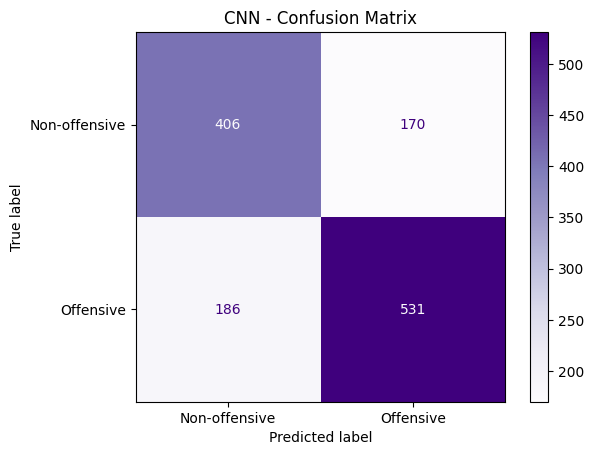


Training LSTM...
Epoch 1/5
146/146 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.6074 - loss: 0.6625 - val_accuracy: 0.6886 - val_loss: 0.5948
Epoch 2/5
146/146 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.7897 - loss: 0.4517 - val_accuracy: 0.7253 - val_loss: 0.6355
Epoch 3/5
146/146 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.8955 - loss: 0.2530 - val_accuracy: 0.6828 - val_loss: 0.8069
Epoch 4/5
146/146 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9482 - loss: 0.1424 - val_accuracy: 0.7041 - val_loss: 0.9375
Epoch 5/5
146/146 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9670 - loss: 0.0983 - val_accuracy: 0.6692 - val_loss: 1.0992
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step

LSTM Accuracy: 0.708430007733952
              precision    recall  f1-score   support

           0       0.68      0.65      0.67       576
           1       0.73      0.75      0.74       717

    accuracy                           0.71      1293
   macro avg       0.70      0.70      0.70      1293
w

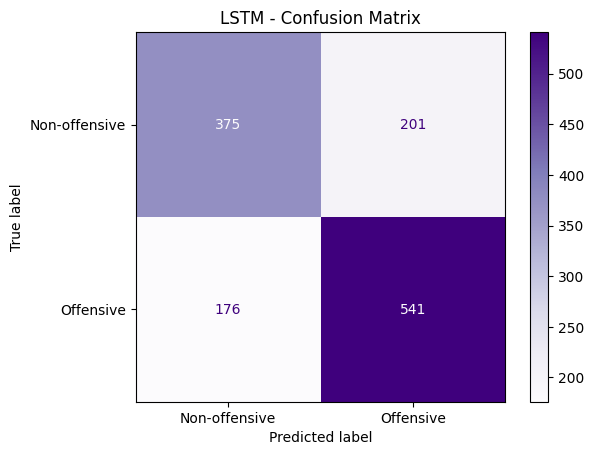


Training CNN_LSTM...
Epoch 1/5
146/146 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.5944 - loss: 0.6607 - val_accuracy: 0.7157 - val_loss: 0.5905
Epoch 2/5
146/146 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.7996 - loss: 0.4421 - val_accuracy: 0.7137 - val_loss: 0.7278
Epoch 3/5
146/146 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9056 - loss: 0.2320 - val_accuracy: 0.7041 - val_loss: 1.1155
Epoch 4/5
146/146 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9591 - loss: 0.1128 - val_accuracy: 0.7099 - val_loss: 1.2124
Epoch 5/5
146/146 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9752 - loss: 0.0672 - val_accuracy: 0.7118 - val_loss: 1.3670
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step

CNN_LSTM Accuracy: 0.6937354988399071
              precision    recall  f1-score   support

           0       0.70      0.54      0.61       576
           1       0.69      0.82      0.75       717

    accuracy                           0.69      1293
   macro avg       0.70      0.68      0.68    

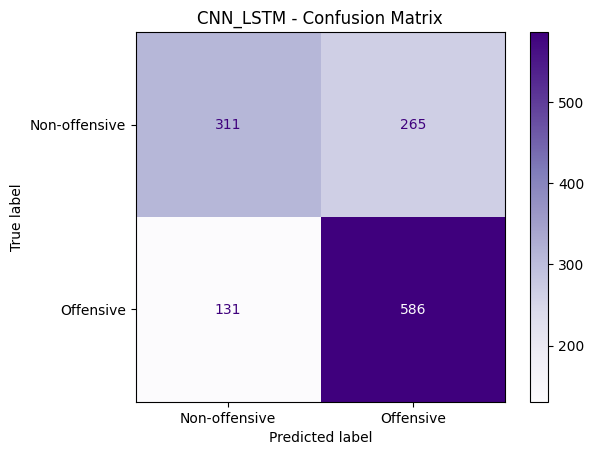


Training BiLSTM...
Epoch 1/5
146/146 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - accuracy: 0.5989 - loss: 0.6634 - val_accuracy: 0.6983 - val_loss: 0.5818
Epoch 2/5
146/146 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.7659 - loss: 0.4926 - val_accuracy: 0.7234 - val_loss: 0.5963
Epoch 3/5
146/146 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.8836 - loss: 0.2894 - val_accuracy: 0.6983 - val_loss: 0.6964
Epoch 4/5
146/146 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.9356 - loss: 0.1691 - val_accuracy: 0.7021 - val_loss: 0.9684
Epoch 5/5
146/146 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.9708 - loss: 0.0963 - val_accuracy: 0.7099 - val_loss: 1.1507
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step

BiLSTM Accuracy: 0.7169373549883991
              precision    recall  f1-score   support

           0       0.72      0.59      0.65       576
           1       0.71      0.82      0.76       717

    accuracy                           0.72      1293
   macro avg       0.72      0.70      0.71   

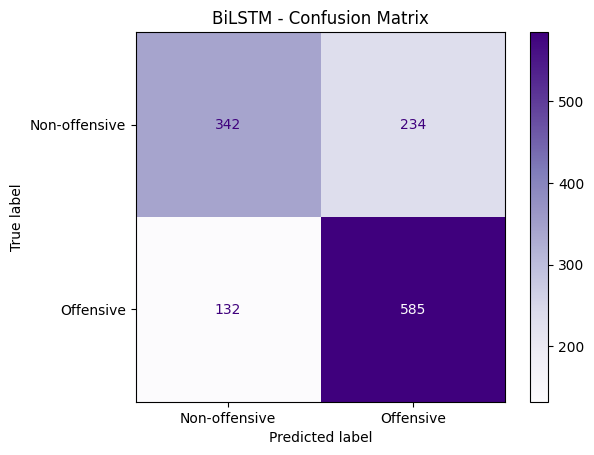


Training CNN_BiLSTM...
Epoch 1/5
146/146 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 0.5789 - loss: 0.6659 - val_accuracy: 0.7041 - val_loss: 0.6014
Epoch 2/5
146/146 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.7917 - loss: 0.4430 - val_accuracy: 0.7021 - val_loss: 0.6698
Epoch 3/5
146/146 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.9057 - loss: 0.2308 - val_accuracy: 0.7041 - val_loss: 0.9013
Epoch 4/5
146/146 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9588 - loss: 0.1174 - val_accuracy: 0.6905 - val_loss: 1.1640
Epoch 5/5
146/146 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9799 - loss: 0.0609 - val_accuracy: 0.7060 - val_loss: 1.3533
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step

CNN_BiLSTM Accuracy: 0.711523588553751
              precision    recall  f1-score   support

           0       0.75      0.53      0.62       576
           1       0.69      0.86      0.77       717

    accuracy                           0.71      1293
   macro avg       0.72      0.69      0

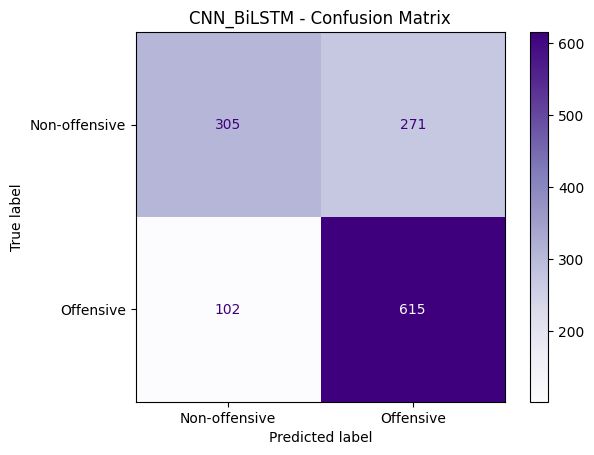

In [ ]:
models = {
    'CNN': build_cnn_model,
    'LSTM': build_lstm_model,
    'CNN_LSTM': build_cnn_lstm_model,
    'BiLSTM': build_bilstm_model,
    'CNN_BiLSTM': build_cnn_bilstm_model
}

for name, fn in models.items():
    train_and_evaluate(fn, name, save=True)


# Deep Learning Models: Evaluation Results

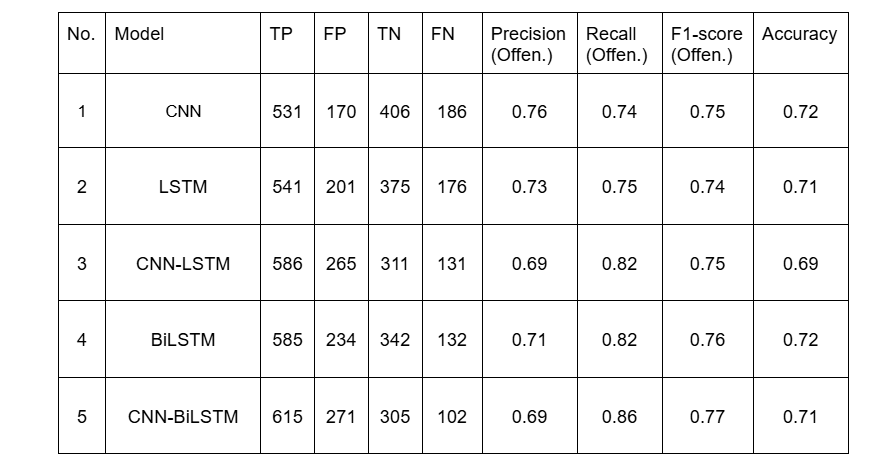